In [108]:
import numpy as np
import pandas as pd
import sklearn as sk
from scipy import stats as st
import matplotlib.pyplot as plt
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

In [109]:
def get_bootstrap_samples(x, n_resamples):
    indices = np.random.randint(0, len(x), (n_resamples, len(x)))
    resamples = x[indices]
    return resamples

def percentile_interval(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# Load the data #

In [110]:
df = pd.read_csv("credit_card_default_analysis.csv", sep=",")
df.head()

,ID,LIMIT_BAL,GENDER,EDUCATION,MARITAL,AGE,PAY_SEP,PAY_AUG,PAY_JUL,PAY_JUN,...,BILL_JUN,BILL_MAY,BILL_APR,PAY_SEP.1,PAY_AUG.1,PAY_JUL.1,PAY_JUN.1,PAY_MAY.1,PAY_APR.1,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Task #1 - Credit limit test ##

$H_0\colon$ Median of the limit for the default group is equals non-default group $F_{X_1}(x) = F_{X_2}(x)$
$H_1\colon$ Median of the limit for the default group is equals non-default group plus some shift delta $F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

### Take corresponding groups ###

In [75]:
default_group_limits = df.loc[df['default'] == 1, ['LIMIT_BAL']]
non_default_group_limits = df.loc[df['default'] == 0, ['LIMIT_BAL']]

### Let's plot bar plots of corresponding groups ###

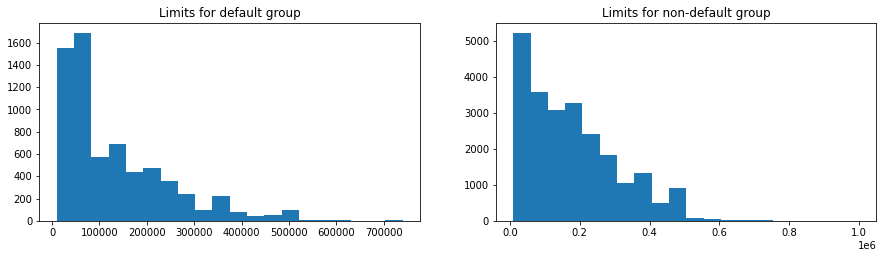

In [76]:
fig = plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1);
plt.title("Limits for default group")
plt.hist(default_group_limits.values, bins=20);

plt.subplot(2, 2, 2);
plt.title("Limits for non-default group")
plt.hist(non_default_group_limits.values, bins=20);

This is shown on the plot, that they look pretty similar, and I supposed the difference only in scale (x10).
First of all need check confidence intervals using bootstrap.

In [112]:
np.random.seed(0)

debt_group_median_scores = list(map(np.median, get_bootstrap_samples(default_group_limits.values, 5000)))
without_debt_group_median_scores = list(map(np.median, get_bootstrap_samples(non_default_group_limits.values, 5000)))

print("95% confidence interval for the debt median group:",  percentile_interval(debt_group_median_scores, 0.05))
print("95% confidence interval for the without debt median group:",  percentile_interval(without_debt_group_median_scores, 0.05))

95% confidence interval for the debt median group: [80000. 90000.]
95% confidence interval for the without debt median group: [150000. 150000.]


Confidence intervals don't cross. First conclusion: difference between medians exists.

### Let's use signed rank test (Mann-Whitney) for comparing medians

In [123]:
U1, p = st.mannwhitneyu(default_group_limits.values, non_default_group_limits.values)
group1_len, group2_len = len(default_group_limits), len(non_default_group_limits)
effect_size = U1 / (group1_len*group2_len)
print(f"P-value: {p}, Effect Size: {effect_size}")

P-value: [1.22554858e-189], Effect Size: [0.38219736]


The result ~ **1.226e-189** is significant at 0.05 level, we reject null hypothesis in favour of alternative. Conclusion: we see the difference between median of groups. Calculated Effect Size : ~ 0.38219736. From practical point of view credit limits for non-debt group definitely higher.

## Task #2 Gender Test ##

### Take corresponding groups

In [114]:
gender_in_default_group_limits = df.loc[df['default'] == 0, ['GENDER']]
gender_in_non_default_group_limits = df.loc[df['default'] == 1, ['GENDER']]

### Let’s plot bar plots of corresponding groups ###

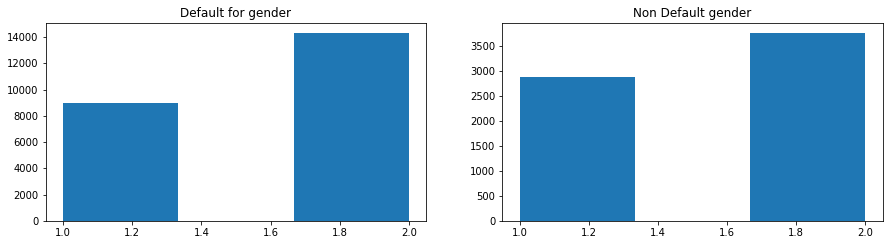

In [115]:
fig = plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1);
plt.title("Default for gender")
plt.hist(gender_in_default_group_limits.values, bins=3);

plt.subplot(2, 2, 2);
plt.title("Non Default gender")
plt.hist(gender_in_non_default_group_limits.values, bins=3);

$H_0\colon$ Composition of genders the same
$H_1\colon$ Composition of genders is different

In both examples amount of woman bigger. But proportions slightly different.
Firstly let's check proportions in debt group.

In [28]:
men_count = df[df['GENDER'] == 1].shape[0]
woman_count = df[df['GENDER'] == 2].shape[0]

men_with_deb = gender_in_default_group_limits[gender_in_default_group_limits['GENDER'] == 1].shape[0]
wo_with_deb = gender_in_default_group_limits[gender_in_default_group_limits['GENDER'] == 2].shape[0]

men_percent_with_deb = men_with_deb / men_count * 100
woman_percent_with_deb = wo_with_deb / woman_count * 100

diff = abs(men_percent_with_deb-woman_percent_with_deb)
print(f'Percent of man in debt group {men_percent_with_deb} %')
print(f'Percent of woman in debt group {woman_percent_with_deb} %')
print(f'Difference : {diff}')

Percent of man in debt group 75.83277254374158 %
Percent of woman in debt group 79.22371908127208 %
Difference : 3.390946537530496


Woman's more frequently become debtors ~3.4%

Again i've decided to use Mann-Whitney U Test as special case of permutation test. The goal is to test the medians. Alternative - two-sided.

In [124]:
U1, p = st.mannwhitneyu(gender_in_default_group_limits.values, gender_in_non_default_group_limits.values)
group1_len, group2_len = len(gender_in_default_group_limits), len(gender_in_non_default_group_limits)
effect_size = U1 / (group1_len*group2_len)
print(f"P-value: {p}, Effect Size: {effect_size}")

P-value: [4.47647869e-12], Effect Size: [0.52354575]


We reject null hypothesis in favor of alternative. P-Value small enough at level $a$=0.05. Effect size big enough (0.52354575). We can say that groups are differ and gender have meaning.

## Task #3 Education Level Test ##

<BarContainer object of 7 artists>

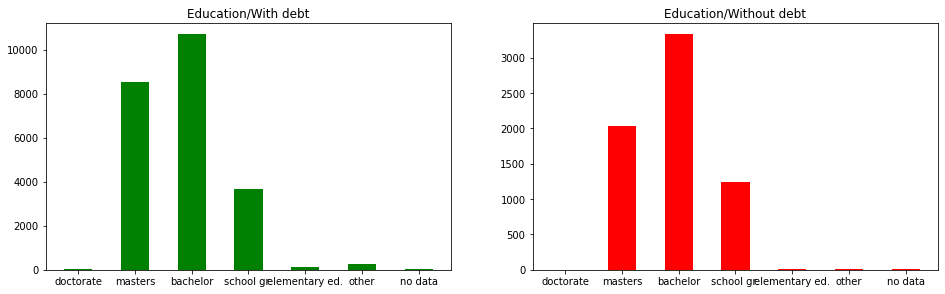

In [117]:
levels = {
    0: "doctorate",
    1: "masters",
    2: "bachelor",
    3: "school gr.",
    4: "elementary ed.",
    5: "other",
    6: "no data"
}

data = pd.DataFrame(pd.crosstab(index=df['default'], columns=df['EDUCATION']));
data.rename(columns=levels, inplace=True);
data.reset_index(drop=True, inplace=True);
data.columns.name = None;

fig = plt.figure(figsize=(16, 10));

plt.subplot(2, 2, 1);
plt.title("Education/With debt");
plt.bar(data.columns, data.values[0], width=0.5, color='g')

plt.subplot(2, 2, 2);
plt.title("Education/Without debt");
plt.bar(data.columns, data.values[1], width=0.5, color='r')

$H_0\colon$ Education levels between two groups the same
$H_1\colon$ Education levels between two groups differs

It is easy to see, that doctorate level almost have no loans, the main part of debtors concentrated in 3 categories: bachelor, masters, school.
For comparing I've decided to use $X^2$ test. Because it is the best option for comparing categorical variables. For calculating an effect size - cramer's v coeff.

In [118]:
data

,doctorate,masters,bachelor,school gr.,elementary ed.,other,no data
0,14,8549,10700,3680,116,262,43
1,0,2036,3330,1237,7,18,8


In [119]:
chi2, p, _, _ = st.chi2_contingency(data.values,  correction=False)
N = np.sum(data.values)
minimum_dimension = min(data.values.shape)-1
print("P-value: ", p)
print("Cramer's V coeff (effect-size): ", np.sqrt((chi2/(len(df) * minimum_dimension))))

P-value:  1.2332626245415605e-32
Cramer's V coeff (effect-size):  0.07376009713252163


And again we reject null hypothesis in favor of alternative. P-Value ~ $1.23326e-32$ small enough at level $a$=0.05. Effect size ~ 0.07376009 - education level has no correlation between groups. As conclusion - education matters.

## Task #4 Marital Test ##

In [120]:
marital_statuses_with_debt = df.loc[df['default'] == 0, ['MARITAL']]
marital_statuses_without_debt = df.loc[df['default'] == 1, ['MARITAL']]

### Bar plot visualising ###

<BarContainer object of 4 artists>

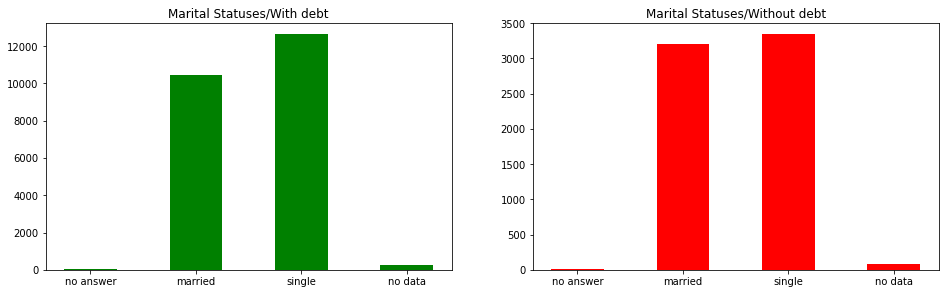

In [121]:
levels = {
    0: "no answer",
    1: "married",
    2: "single",
    3: "no data",
}

data = pd.DataFrame(pd.crosstab(index=df['default'], columns=df['MARITAL']));
data.rename(columns=levels, inplace=True);
data.reset_index(drop=True, inplace=True);
data.columns.name = None;

fig = plt.figure(figsize=(16, 10));

plt.subplot(2, 2, 1);
plt.title("Marital Statuses/With debt");
plt.bar(data.columns, data.values[0], width=0.5, color='g')

plt.subplot(2, 2, 2);
plt.title("Marital Statuses/Without debt");
plt.bar(data.columns, data.values[1], width=0.5, color='r')

Two groups are leaders on both plots: "Married" and "Single".

$H_0\colon$ Marital statuses composition between two groups the same
$H_1\colon$ Marital statuses composition between two groups differs

Because it is categorical variable I applied the same approach as for education test. $X^2$ Test and $Cramer V$ coefficient as effect size.

In [122]:
chi2, p, _, _ = st.chi2_contingency(data.values,  correction=False)
N = len(df)
minimum_dimension = min(data.shape)-1
print("P-value: ", p)
print("Cramer's V coeff (effect-size): ", np.sqrt(chi2/(N*minimum_dimension)))

P-value:  8.825862457577375e-08
Cramer's V coeff (effect-size):  0.034478203662766466


And again we reject null hypothesis in favor of alternative. P-Value ~ $8.825862e-08$ small enough at level $a$=0.05. Effect size ~ 0.034478203 - marital status has no correlation between groups. Practical conclusion - we should pay attention to status of person if we want give a loan.

## Task #5 Age Test ##

In [100]:
age_with_debt = df.loc[df['default'] == 0, ['AGE']]
age_without_debt = df.loc[df['default'] == 1, ['AGE']]

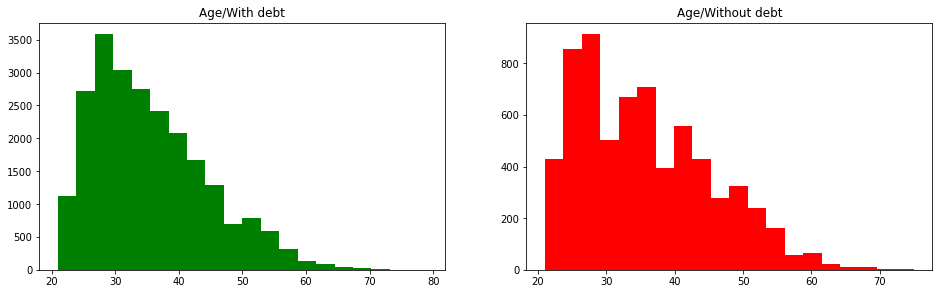

In [101]:
fig = plt.figure(figsize=(16, 10));

plt.subplot(2, 2, 1);
plt.title("Age/With debt");
plt.hist(age_with_debt, color='g', bins=20);

plt.subplot(2, 2, 2);
plt.title("Age/Without debt");
plt.hist(age_without_debt, color='r', bins=20);

Distribution looks similar. Time to test median using famous Mann-Whitney U Test.

$H_0\colon$ Age median of two groups the same $F_{X_1}(x) = F_{X_2}(x)$
$H_1\colon$ Age median of two groups differs by shift $F_{X_1}(x) = F_{X_2}(x + \Delta)$

In [126]:
U1, p = st.mannwhitneyu(age_with_debt.values, age_without_debt.values)
group1_len, group2_len = len(age_with_debt), len(age_without_debt)
effect_size = U1 / (group1_len*group2_len)
print(f"P-value: {p}, Effect Size: {effect_size}")

P-value: [0.37250354], Effect Size: [0.49642118]


We cannot reject null hyphotesis at level $a$=0.05 (P-value: 0.37250354). Effect size also shows large ~ 0.49642. Surprisingly, but age have no influence on probability fall into debt group.

Let's also check distributions of samples using Kolmogorov-Smirnov test.
$H_0\colon$ Distribution of age in two groups the same
$H_1\colon$ Distribution of age in two groups differs


In [65]:
stat, p = st.ks_2samp(age_with_debt.values.reshape(-1), age_without_debt.values.reshape(-1))
print(f"P-value: {p}")

P-value: 1.2584243902803685e-05


We reject null hypothesis in favor of alternative. P-Value ~ $1.258424e-05$ small enough at level $a$=0.05. Distribution of ages is differs.